# Example EDA of toxicity annotation dataset

## Step 1: Download datasets

## Step 2: Load tables using pandas

In [40]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [41]:
aggression_annotations = pd.read_csv("aggression_annotations.tsv", delimiter="\t")
aggression_annotated_comments = pd.read_csv("aggression_annotated_comments.tsv", delimiter="\t")
aggression_worker_demographics = pd.read_csv("aggression_worker_demographics.tsv", delimiter="\t")

Briefly inspect each table.

In [42]:
aggression_annotations.head()

,rev_id,worker_id,aggression,aggression_score
0,37675,1362,1.0,-1.0
1,37675,2408,0.0,1.0
2,37675,1493,0.0,0.0
3,37675,1439,0.0,0.0
4,37675,170,0.0,0.0


In [43]:
aggression_annotated_comments.head()

,rev_id,comment,year,logged_in,ns,sample,split
0,37675,`-NEWLINE_TOKENThis is not ``creative``. Thos...,2002,True,article,random,train
1,44816,`NEWLINE_TOKENNEWLINE_TOKEN:: the term ``stand...,2002,True,article,random,train
2,49851,"NEWLINE_TOKENNEWLINE_TOKENTrue or false, the s...",2002,True,article,random,train
3,89320,"Next, maybe you could work on being less cond...",2002,True,article,random,dev
4,93890,This page will need disambiguation.,2002,True,article,random,train


In [44]:
aggression_worker_demographics.head()

,worker_id,gender,english_first_language,age_group,education
0,833,female,0,45-60,bachelors
1,1072,male,0,30-45,bachelors
2,872,male,0,18-30,hs
3,2116,male,0,30-45,professional
4,453,male,0,30-45,hs


## Step 3: Join annotation table to demographics table

In [45]:
joined_annotations = pd.merge( aggression_annotations, aggression_worker_demographics, left_on="worker_id", right_on="worker_id")

In [55]:
joined_annotations.shape

(855514, 8)

In [56]:
joined_annotations.head()

,rev_id,worker_id,aggression,aggression_score,gender,english_first_language,age_group,education
0,37675,1362,1.0,-1.0,male,0,18-30,masters
1,3202092,1362,0.0,0.0,male,0,18-30,masters
2,4745553,1362,0.0,0.0,male,0,18-30,masters
3,4855563,1362,0.0,0.0,male,0,18-30,masters
4,8350378,1362,0.0,0.0,male,0,18-30,masters


In [61]:
joined_annotations[ ( joined_annotations.gender == "male" ) ].shape

(547328, 8)

## Basic EDA

At this point you start asking question.

I can calculate the average score per worker - that worker's "toxicity bias". Is this different for different age groups?

In [47]:
avg_worker_aggression = joined_annotations.groupby("worker_id")["aggression_score"].mean()
aggression_worker_demographics = aggression_worker_demographics.join( avg_worker_aggression )

Take a quick look at our newly augmented table.

In [48]:
aggression_worker_demographics.head()

,worker_id,gender,english_first_language,age_group,education,aggression_score
0,833,female,0,45-60,bachelors,-0.461388
1,1072,male,0,30-45,bachelors,NaN
2,872,male,0,18-30,hs,NaN
3,2116,male,0,30-45,professional,NaN
4,453,male,0,30-45,hs,-0.233405


Now let's compute an average toxicity statistic for each group...

In [49]:
aggression_worker_demographics.groupby("age_group").aggression_score.mean()

age_group
18-30      -0.153928
30-45      -0.169478
45-60      -0.188123
Over 60    -0.011484
Under 18   -0.265388
Name: aggression_score, dtype: float64

The "toxicity bias" does vary by group!

We can even plot the distribution of personal biases in each group:

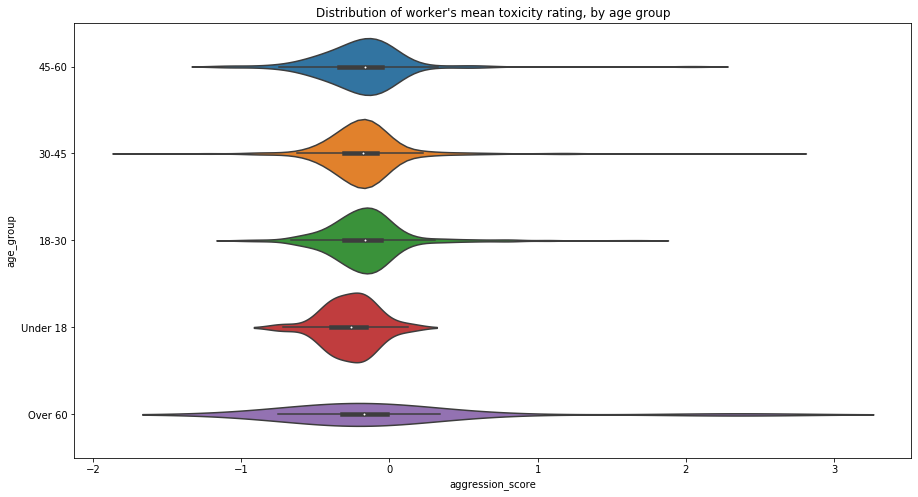

In [50]:
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title("Distribution of worker's mean toxicity rating, by age group")
sns.violinplot( x="aggression_score", y="age_group", data=aggression_worker_demographics, ax=ax )

## A very basic bias question: is the set of annotation workers gender-balanced?

In [51]:
foo = aggression_worker_demographics.groupby("gender").worker_id.count()
foo/foo.sum()

gender
female    0.383562
male      0.615982
other     0.000457
Name: worker_id, dtype: float64

The answer is **no** - 64.8% of annotators are male.

## Is the set of _annotations_ gender-balanced?

In [52]:
foo = joined_annotations.groupby("gender").rev_id.count()
foo/foo.sum()

gender
female    0.360138
male      0.639765
other     0.000097
Name: rev_id, dtype: float64

Also no, about the same fraction - 64.8% of annotations - were made by male annotators.